In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
import time
import sympy
from sympy import lambdify
from eqlearner.dataset.univariate.datasetcreator import DatasetCreator
from eqlearner.dataset.processing import tokenization
from sympy import sin, Symbol, log, exp 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torchtext.datasets 
from torchtext.data import Field, BucketIterator
import matplotlib.pyplot as plt
#from eq_learner.processing import dataset

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
class TensorDataset(Dataset):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Arguments:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """

    def __init__(self, *tensors):
        self.tensors = tensors

    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)
    
def dataset_loader(train_dataset,test_dataset, batch_size = 1024, valid_size = 0.20):
    num_train = len(train_dataset)
    num_test_h = len(test_dataset)
    indices = list(range(num_train))
    test_idx_h = list(range(num_test_h))
    np.random.shuffle(test_idx_h)
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
        sampler=train_sampler, num_workers=0)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=0)
    test_loader_h = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
        shuffle=False, num_workers=0)
    return train_loader, valid_loader, test_loader_h, valid_idx, train_idx


sin(log(x)**3+log(x))
[12  2  5  4  5  1  6  7 18  9  4  5  1  6  6 13]


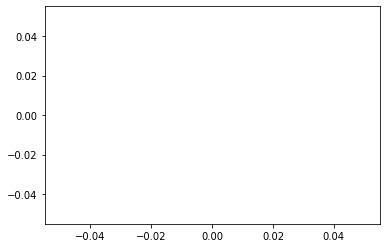

In [6]:
scale = True
scaler = MinMaxScaler()
x = Symbol('x', real=True)
basis_functions = [x,sin,log,exp]
support = np.arange(0.1,3.1,0.1)
fun_generator = DatasetCreator(basis_functions,max_linear_terms=1, max_binomial_terms=1,max_compositions=1,max_N_terms=1,division_on=False,  random_terms=True, constants_enabled = True, constant_intervals_ext=[(-10,1),(1,10)], constant_intervals_int = [(1,3)])
string, dictionary = fun_generator.generate_batch(support,1, X_noise=False, Y_noise=0)
print(tokenization.get_string(tokenization.pipeline(dictionary)[0]))
print(tokenization.pipeline(dictionary)[0])
plt.plot(string[0][1])

In [7]:
train_eqs = 50000 #Number of equations needed for training
test_eqs = 1000
scale = True
scaler = MinMaxScaler()
x = Symbol('x', real=True)
basis_functions = [x,sin,log,exp]
support = np.arange(0.1,3.1,0.1)
fun_generator = DatasetCreator(basis_functions,max_linear_terms=1, max_binomial_terms=1,max_compositions=1,max_N_terms=0,division_on=False,  random_terms=True, constants_enabled = True, constant_intervals_ext=[(-3,1),(1,3)], constant_intervals_int = [(1,3)])
x_train = []
y_train = []
cnt = 0
cond = True
while cond == True:
    string, dictionary =  fun_generator.generate_batch(support,1, X_noise=False, Y_noise=0)
    if np.all(string[0][1] == 0) == False:
        if np.max(string[0][1])<1000 and np.min(string[0][1])>-1000 and tokenization.get_string(tokenization.pipeline(dictionary)[0])[-1] != '+': 
            x_train.append(string[0][1])
            y_train.append(torch.Tensor((tokenization.pipeline(dictionary)[0])))
#             print(tokenization.get_string(tokenization.pipeline(dictionary)[0]))
            cnt+=1
            #print(cnt)
    if cnt == train_eqs:
        cond = False
scaler.fit(np.array(x_train).T)
x_train_n = scaler.transform(np.array(x_train).T)
x_train_n = torch.Tensor(x_train_n)
l = [len(y) for y in y_train]
q = np.max(l)
y_train_p = torch.zeros(len(y_train),q)
for i,y in enumerate(y_train):
    y_train_p[i,:] = torch.cat([y,torch.zeros(q-y.shape[0])])
train_data = TensorDataset(x_train_n.T,y_train_p.long())
print('train', len(train_data), len(train_data[0][0]), len(train_data[0][1]))

x_test = []
y_test = []
cnt = 0
cond = True
while cond == True:
    string, dictionary =  fun_generator.generate_batch(support,1, X_noise=False, Y_noise=0)
    if np.all(string[0][1] == 0) == False:
        if np.max(string[0][1])<1000 and np.min(string[0][1])>-1000 and tokenization.get_string(tokenization.pipeline(dictionary)[0])[-1] != '+': 
            x_test.append(string[0][1])
            y_test.append(torch.Tensor((tokenization.pipeline(dictionary)[0])))
            #print(tokenization.get_string(tokenization.pipeline(dictionary)[0]))
            cnt+=1
            #print(cnt)
    if cnt == test_eqs:
        cond = False
scaler = MinMaxScaler()
x_test_n = scaler.fit_transform(np.array(x_test).T)
x_test_n = torch.Tensor(x_test_n)
l = [len(y) for y in y_test]
q = np.max(l)
y_test_p = torch.zeros(len(y_test),q)
for i,y in enumerate(y_test):
    y_test_p[i,:] = torch.cat([y,torch.zeros(q-y.shape[0])])
test_data = TensorDataset(x_test_n.T,y_test_p.long())
print('test', len(test_data), len(test_data[0][0]), len(test_data[0][1]))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-6dcde0f0d1c3>", line 14, in <module>
    string, dictionary =  fun_generator.generate_batch(support,1, X_noise=False, Y_noise=0)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/eqlearner/dataset/univariate/datasetcreator.py", line 178, in generate_batch
    fun, dictionary, dictionary_cleaned = self.generate_fun()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/eqlearner/dataset/univariate/datasetcreator.py", line 74, in generate_fun
    self.symbol, constant_interval=self.interval_int)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/eqlearner/dataset/univariate/eqgenerator.py", line 73, in polynomial_single
    elem_wit

KeyboardInterrupt: 

In [ ]:
print('train', len(train_data), len(train_data[0][0]), len(train_data[0][1]))
print('test', len(test_data), len(test_data[0][0]), len(test_data[0][1]))

## Preparing Neural Network

In [17]:
# torch.save(train_data, 'train_data_int_comp.pt') 
# torch.save(test_data, 'test_data_int_comp.pt') 
train_data = torch.load('train_data_int_comp.pt')
test_data = torch.load('test_data_int_comp.pt')

for i in train_data:
    size_vec=i[1]
    break
print(len(size_vec))
train_data[0][1].shape
print('train', len(train_data), len(train_data[0][0]), len(train_data[0][1]))
print('test', len(test_data), len(test_data[0][0]), len(test_data[0][1]))

67
train 50000 30 67
test 1000 30 67


In [18]:
train_loader, valid_loader, test_loader, valid_idx, train_idx = dataset_loader(train_data,test_data, batch_size = 2000, valid_size = 0.30)

In [19]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 30):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.relu = nn.ReLU()
        
        self.tok_linear = nn.Linear(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        
        #pos = [batch size, src len]
        
        #embed tokens and positions

        src = torch.unsqueeze(src,dim = 2)
        
        tok_embedded = ((self.tok_linear(src)))
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

In [20]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 36):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.relu = nn.ReLU()
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out((conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

In [22]:
INPUT_DIM = 1
OUTPUT_DIM = 22 # dictionary size
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 2 # number of conv. blocks in encoder 10 original
DEC_LAYERS = 2 # number of conv. blocks in decoder 10 original
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = 0
DEC_MAX_LENGTH = 67 # length of longest equation in terms of numbe of tokens
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, max_length=DEC_MAX_LENGTH)

model = Seq2Seq(enc, dec).to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = 0)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The model has 7,120,918 trainable parameters


In [23]:
def train(model, iterator, optimizer, criterion, clip, noise_Y=False,sigma = 0.1):
    
    model.train()
    
    epoch_loss = 0
    print('batch_size = ', len(iterator))
#     print('size of each batch =', len(iterator[0]))
    
    for i, batch in enumerate(iterator):
        print('.', end='', flush=True)
        if noise_Y:
            src = batch[0] + torch.from_numpy(sigma*np.random.randn(batch[0].shape[0],30)).float().cuda()
            trg = batch[1]
        else:
            src = batch[0]
            trg = batch[1]
        
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
    
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
       

        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    print('')
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0]
            trg = batch[1]

            output, _ = model(src, trg[:,:-1])

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)


            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
N_EPOCHS = 2

CLIP = 1

best_valid_loss = float('inf')
torch.set_num_threads (1)

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP,noise_Y = False,sigma = 0.05)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cnn.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}) | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}) |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch_size =  18
.

KeyboardInterrupt: 

In [139]:
model.load_state_dict(torch.load('cnn.pt'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.555 | Test PPL:   1.742 |


<function _lambdifygenerated at 0x1373bb0e0>
begin eval
end eval
begin num_eval
2 100 60 22 100 60 30
tensor([-1.6667,  8.4111,  8.7091,  7.8522,  8.3418, -1.0293, -2.6815, -1.9414,
        -1.4093, -3.6589, -2.2632, -2.4885, -1.0625, -1.2075, -1.9873, -0.7787,
         3.0040,  0.5442,  0.0387, -1.4155, -1.2134, -1.1597])
Prediction:  sin(x)
Ground Truth:  sin(x**3+x**2+x)
MSE:  0.9300516141624355
[-0.15004108 -0.31491521 -0.50021323 -0.70618886 -0.92304159 -1.12412966
 -1.25842386 -1.24732916 -0.99757959 -0.44817177  0.33739571  1.06734119
  1.23868239  0.48036685 -0.79793375 -1.22218836  0.0647583   1.27560476
 -0.01259406 -1.24371087  0.74034273  0.47828676 -1.1897875   1.23791272
 -1.00555228  0.82506435 -0.84056865  1.04825983 -1.26676955  1.05431457]
end num_eval


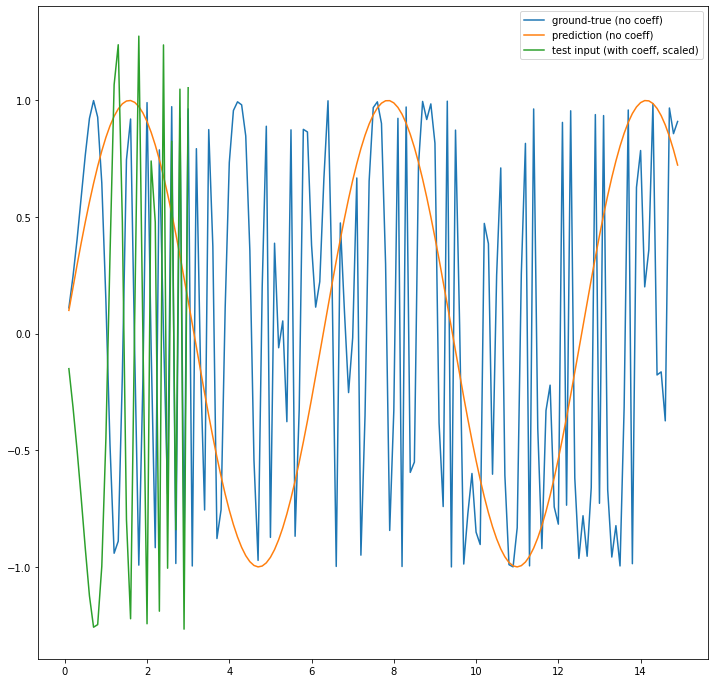

In [215]:
import tokenize
f = lambdify(x, 'sin(x)')
print(f)

def num_evaluation(model_o,y_test,n):
    # model_o[0] is the output, model_o[1] is attention
    # model_o[0].shape = batch_size, length, OUTPUT_DIM
    print(len(model_o), len(model_o[0]), len(model_o[0][0]), len(model_o[0][0][0]), len(model_o[1]), len(model_o[1][0]), len(model_o[1][0][0]))
    print(model_o[0][0][0])
    c = True
    i=0
    enc_eq = np.array([12]+list(np.argmax(model_o[0], axis=2)[n]))

    while c:
        try:
            fun = lambdify(x,tokenization.get_string(enc_eq[:-i]))
            print('Prediction: ', tokenization.get_string(enc_eq[:-i]))
            c = False
        except (sympy.SympifyError, tokenize.TokenError, TypeError) as e:
            i+=1
        if i > DEC_MAX_LENGTH:
            break
    print('Ground Truth: ', tokenization.get_string(y_test[n].numpy()))
    trueth = lambdify(x,tokenization.get_string(y_test[n].numpy()))
    enlarged_supp = np.arange(0.1,15,0.1)
    supp = np.arange(0.1,3.1,0.1)
    MSE = np.mean((trueth(enlarged_supp)-fun(enlarged_supp))**2)
    print('MSE: ', MSE)
    plt.figure(figsize=(12,12))
    plt.plot(enlarged_supp,trueth(enlarged_supp), label = 'ground-true (no coeff)')
    plt.plot(enlarged_supp,fun(enlarged_supp), label = 'prediction (no coeff)')
    plt.plot(supp,x_test[n], label = 'test input (with coeff, scaled)')
    print(x_test[n])
    plt.legend()
#    plt.ylim(0,10)
#    plt.xlim(0,3)
print('begin eval')
model.eval()
print('end eval')
with torch.no_grad():
#     print(x_test_n.T[0], y_test_p[0])
    a = model(x_test_n.T[:1000], y_test_p[:1000].long())
#     print(a[0])
#     print(np.argmax(a[0], axis=2))
print('begin num_eval')
num_evaluation(a,y_test,1)
print('end num_eval')

In [ ]:
___x = np.array([[[-1.6667,  8.4111,  8.7091,  7.8522,  8.3418, -1.0293, -2.6815, -1.9414,
        -1.4093, -3.6589, -2.2632, -2.4885, -1.0625, -1.2075, -1.9873, -0.7787,
         3.0040,  0.5442,  0.0387, -1.4155, -1.2134, -1.1597],[-1.6667,  8.4111,  8.7091,  7.8522,  8.3418, -1.0293, -2.6815, -1.9414,
        -1.4093, -3.6589, -2.2632, -2.4885, -1.0625, -1.2075, -1.9873, -0.7787,
         3.0040,  0.5442,  0.0387, -1.4155, -1.2134, -1.1597]]])
print(___x)
print(___x[0][0][0])
print(np.argmax(___x, axis=2))

In [207]:
def user_eval(support, model, y_test_p):
    model.eval()
    expression = input()
    av = lambdify(x,expression)
    xxx = av(support)
    scaler = MinMaxScaler()
    xxx_n = scaler.fit_transform(np.expand_dims(xxx,0).T)
    #print(xxx_n.T)
    x_new = torch.from_numpy(xxx_n.T).float()
    with torch.no_grad():
        pred = model(x_new,y_test_p[:1].long())
        pred = pred[0].permute(1,0,2)
        print(pred.shape)
        enc_eq = np.array([12]+list(np.argmax(pred[0], axis=2)[n]))

        print(tokenization.get_string(enc_eq))
        c = True
        i=0
        while c:
            try:
                fun = lambdify(x,tokenization.get_string(enc_eq[:-i]))
                print('Prediction: ', tokenization.get_string(enc_eq[:-i]))
                c = False
            except:
                i+=1
                if i >30:
                    break
            
        print('Ground Truth: ', expression)
        ss = np.arange(0.1,15.1,0.1)
        enlarged_supp = np.arange(0.1,3.1,0.1)
        MSE = np.mean((av(enlarged_supp)-fun(enlarged_supp))**2)
        print('MSE: ', MSE)
        plt.figure(figsize=(12,12))
        plt.plot(enlarged_supp,scaler.fit_transform(np.expand_dims(av(enlarged_supp),1))[:,0], label = 'ground-true')
        plt.plot(enlarged_supp,scaler.fit_transform(np.expand_dims(fun(enlarged_supp),1))[:,0], label = 'prediction')
        plt.figure(figsize=(12,12))
        plt.plot(ss,(np.expand_dims(av(ss),1))[:,0], label = 'ground-true')
        plt.plot(ss,(np.expand_dims(fun(ss),1))[:,0], label = 'prediction')
        plt.legend()
        #plt.ylim(-4,10)
        #print(scaler.fit_transform(np.expand_dims(fun(support),1)).T)
        return pred

prob = user_eval(support, model,size_vec.unsqueeze(0))

KeyboardInterrupt: Interrupted by user